# Quantum embeddings

We seek to encode a feature vector $\mathbb{R}^N$ in any quantum form. Or better to encode a dataset $(\mathbb{R}^N)^M$ of such vectors.

This [Pennylane tutorial](https://pennylane.ai/qml/glossary/quantum_embedding.html) proposes 2 techniques of encoding datasets.
- First rely on binary vectors, which can be assumed as states, and dataset is a superposition on these states. Preparation is straightforward idealogically, but tricky in practice. Also, binary vectors are not exactly what we want.
- Another approach is to flatten the dataset, such that for $M\times N$ values (state amplitudes) we will need $\log_2(M\times N)$ qubits. The question is open - how to prepare the vector.

This [paper](https://arxiv.org/pdf/quant-ph/0407010.pdf) is where everything started from. It utilizes the idea, that $U|a\rangle=|b\rangle$ in actually $A|a\rangle=|r\rangle=B|b\rangle$, thus $B^\dagger A|a\rangle=|b\rangle$. And if $|a\rangle=|r\rangle=|0\rangle$, then we can search for $B$ -- for any vector equalized phases, and then for real-values vector equalizes amplitudes with a sequence of controlled rotations.

This [Nature paper](https://www.nature.com/articles/s41598-021-85474-1.pdf) proposes DnC method, very similar to merge sort, which allocated 2N memory (uses O(N) ancillary qubit to "hide" entanglements) and solves the problem in linear time.

And [this book](https://link.springer.com/book/10.1007/978-3-319-96424-9) in chapter 3.4. expands other strategies.

### Let's do a phase encoding of 4-element vector and estimate complexity.

This simple example takes the essence of encoding. It uses ancilla qubit to "hide" entanglements and it uses controlled rotation for each state.

In [17]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit import execute, Aer
import matplotlib.pyplot as plt
from qiskit.circuit.library import RZGate, ZGate

import numpy as np
vec = np.array([[0., 5., 2., 8.]]).T
normed = vec / 32
angles = normed * 2 * np.pi
print(angles)

qr = QuantumRegister(2, "q")
ancilla = QuantumRegister(1, "a")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, ancilla, cr)

# equal amplitude superposition
qc.h(qr)
qc.h(ancilla)

# for each state
for i in range(2 ** 2):
    bs = f"{i:02b}"
    
    # prepare controlled rotation
    cccrz = RZGate(-angles[i, 0]).control(2)
    
    # set X (q = 1) where 0 supposed to be
    # as controlled operations fire on "all ones"
    # thus we temporary swap states
    for c, qb in zip(bs[::-1], qr):
        if c == '0': qc.x(qb)
    
    # add rotation
    qc.append(cccrz, qr[:] + ancilla[:])
    
    # cancel presets
    for c, qb in zip(bs[::-1], qr):
        if c == '0': qc.x(qb)
            
    qc.barrier()
    
display(qc.draw())

job = execute(qc, Aer.get_backend('statevector_simulator'))
result = job.result()

import cmath
vector = list(result.get_statevector(qc))
print(vector)
for i, v in enumerate(vector[:4]):
    print(f"{i:02b}: φ={cmath.phase(v) * 2:.4f}")

[[0.        ]
 [0.9817477 ]
 [0.39269908]
 [1.57079633]]


┌───┐┌───┐         ┌───┐ ░                          ░ ┌───┐            »
q_0: ┤ H ├┤ X ├────■────┤ X ├─░────────────■─────────────░─┤ X ├─────■──────»
     ├───┤├───┤    │    ├───┤ ░ ┌───┐      │       ┌───┐ ░ └───┘     │      »
q_1: ┤ H ├┤ X ├────■────┤ X ├─░─┤ X ├──────■───────┤ X ├─░───────────■──────»
     ├───┤└───┘┌───┴───┐└───┘ ░ └───┘┌─────┴──────┐└───┘ ░      ┌────┴─────┐»
  a: ┤ H ├─────┤ Rz(0) ├──────░──────┤ Rz(-5π/16) ├──────░──────┤ Rz(-π/8) ├»
     └───┘     └───────┘      ░      └────────────┘      ░      └──────────┘»
c: 2/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐ ░              ░ 
«q_0: ┤ X ├─░──────■───────░─
«     └───┘ ░      │       ░ 
«q_1: ──────░──────■───────░─
«           ░ ┌────┴─────┐ ░ 
«  a: ──────░─┤ Rz(-π/2) ├─░─
«           ░ └──────────┘ ░ 
«c: 2/═══════════════════════
«

[(0.35355339059327373+0j), (0.31180625324666783+0.16666391461943664j), (0.3467599613305369+0.06897484482073575j), (0.25000000000000006+0.25000000000000006j), (0.3535533905932737+0j), (0.3118062532466678-0.16666391461943653j), (0.3467599613305368-0.06897484482073574j), (0.25-0.25000000000000006j)]
00: φ=0.0000
01: φ=0.9817
10: φ=0.3927
11: φ=1.5708


/var/folders/fl/z0229whs3pq84bw5hs9y42x80000gn/T/ipykernel_71677/3063097606.py:50: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  vector = list(result.get_statevector(qc))


     ┌───┐┌───┐         ┌───┐ ░                          ░ ┌───┐            »
q_0: ┤ H ├┤ X ├────■────┤ X ├─░────────────■─────────────░─┤ X ├─────■──────»
     ├───┤├───┤    │    ├───┤ ░ ┌───┐      │       ┌───┐ ░ └───┘     │      »
q_1: ┤ H ├┤ X ├────■────┤ X ├─░─┤ X ├──────■───────┤ X ├─░───────────■──────»
     ├───┤└───┘┌───┴───┐└───┘ ░ └───┘┌─────┴──────┐└───┘ ░      ┌────┴─────┐»
  a: ┤ H ├─────┤ Rz(0) ├──────░──────┤ Rz(-5π/16) ├──────░──────┤ Rz(-π/8) ├»
     └───┘     └───────┘      ░      └────────────┘      ░      └──────────┘»
c: 2/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐ ░              ░ ┌───┐┌───┐   ┌───┐┌───┐┌─┐   
«q_0: ┤ X ├─░──────■───────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├┤M├───
«     └───┘ ░      │       ░ ├───┤├───┤ │ ├───┤├───┤└╥┘┌─┐
«q_1: ──────░──────■───────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─╫─┤M├
«           ░ ┌────┴─────┐ ░ ├───┤├───┤ │ ├───┤├───┤ ║ └╥┘
«  

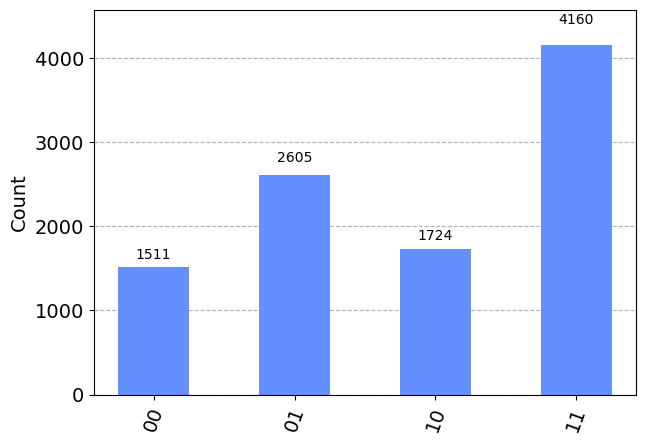

In [18]:
qc.h(qr)
qc.h(ancilla)
qc.x(qr)
qc.x(ancilla)
qc.append(ZGate().control(2), [qr[0], qr[1], ancilla[0]])
qc.x(qr)
qc.x(ancilla)
qc.h(qr)
qc.h(ancilla)

qc.measure(qr, cr)

print(qc.draw())

job = execute(qc, Aer.get_backend('qasm_simulator'), shots=10000)
counts = job.result().get_counts(qc)
plot_histogram(counts)
# print(sorted(list(counts.items())))

## The following video gives an idea about using qiskit for arbitrary initialization.

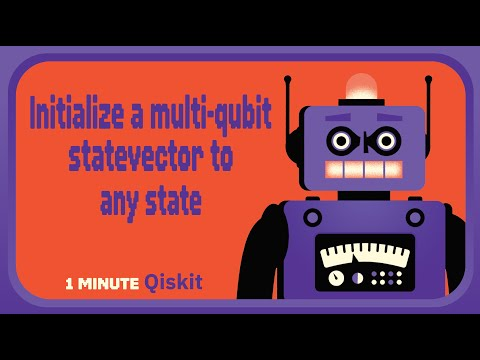

In [14]:
from IPython.display import YouTubeVideo
YouTubeVideo('tOWV94-ydL4')

## TODO
Initialize amplitude-encoded vector using `qc.initialize(data, register)`

In [4]:
## TODO you code here